# Sample of plots for converted umnsaa_pc20060515

Cartopy packages for map plotting

Matplotlib packages for other plotting

Add some plotting config and the locations of data files here

In [1]:
# Show plots in the browser
#%matplotlib inline
%matplotlib notebook

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
# mapping libraries
import cartopy
import cartopy.feature as cpf
# geometry to add onto cartopy
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.transforms import offset_copy

# helper package for dealing with indices or cross sections etc
# repeated stuff in this notebook will probably be refactored to the utils or plotting package
from utilities import utils, fio, constants, plotting

# Plot defaults
plotting.init_plots()

# Data file locations
pafile = 'data/umnsaa_pa2016010515.nc'
pcfile = 'data/umnsaa_pc2016010515.nc'

# Projection used in cartopy
proj = cartopy.crs.PlateCarree()


##### Show the map of Waroona

Nearby terrain shown along with synoptic region inset for context

Perth and Waroona shown on the map too

<IPython.core.display.Javascript object>


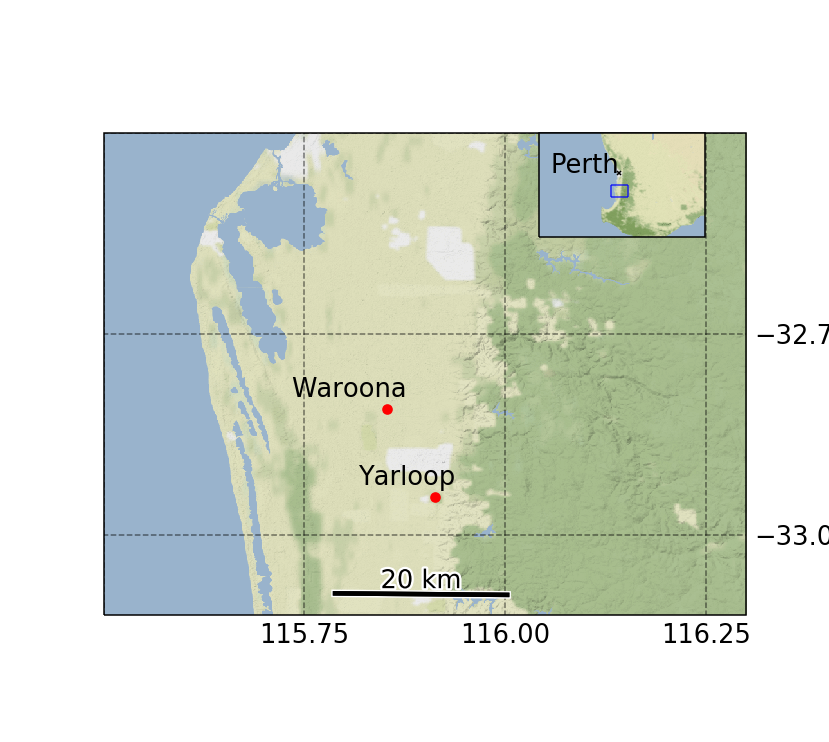

In [2]:
extents = plotting._extents_
latlons = plotting._latlons_

plt.close()
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
proj = cartopy.crs.PlateCarree()
fig = plt.figure()
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=proj)#stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 14.
ax.add_image(stamen_terrain, 11)

# Grid lines and labels
gl = ax.gridlines(crs=proj, linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right=True
gl.xlines = True
gl.xlocator = mpl.ticker.FixedLocator(np.arange(110,120,0.25))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(-40,-10,0.25))

# Add a marker for waroona volcano. LON, LAT, ... argument order important!
plt.plot(latlons['waroona'][1], latlons['waroona'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)
plt.plot(latlons['yarloop'][1], latlons['yarloop'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)
plt.plot(latlons['fire_waroona'][1], latlons['fire_waroona'][0],
         color='red', linewidth=0, marker='*',
         transform=proj)

dx,dy = 0.025,0.015
plt.text(latlons['waroona'][1]+dx, latlons['waroona'][0]+dy, 'Waroona',
         horizontalalignment='right',
         transform=proj)
plt.text(latlons['yarloop'][1]+dx, latlons['yarloop'][0]+dy, 'Yarloop',
         horizontalalignment='right',
         transform=proj)

# Add scale
plotting.scale_bar(ax,proj,20)

# Show synoptic area for reference
sub_ax = plt.axes([0.65, 0.65, 0.2, 0.2], projection=proj)
sub_ax.set_extent(extents['waroonas'], crs=proj)

# Add the Stamen data.
sub_ax.add_image(stamen_terrain, 7)

# Add Perth
plt.plot(latlons['perth'][1], latlons['perth'][0],
         color='black', linewidth=0, marker='x', markersize=3,
         transform=proj)

dx,dy = 0.025,0.015
plt.text(latlons['perth'][1]+dx, latlons['perth'][0]+dy, 'Perth',
         horizontalalignment='right',
         transform=proj)

# add lat,lon boundaries as area marker
drawbox=extents['waroona']
gl2 = sub_ax.gridlines(crs=proj, linewidth=1, color='blue', alpha=0.8, linestyle='-', draw_labels=False)
gl2.xlocator = mpl.ticker.FixedLocator([drawbox[0],drawbox[1]])
gl2.ylocator = mpl.ticker.FixedLocator([drawbox[2],drawbox[3]])

plt.show()

### Try again using google map to show Waroona, Yarloop

Request map from google, add sub_ax map, add scale, maybe add ignition point?


In [1]:
plotting.init_plots()
extents = plotting._extents_
latlons = plotting._latlons_

topog,latt,lont = fio.read_topog()

# Google map image tiles view of synoptic map
fig,ax,proj=plotting.map_google(extents['waroonas'],
                                zoom=6,
                                subplotxyn=[2,1,1],
                                gridlines=[np.arange(-51,-10,2),
                                           np.arange(100,150,4)])
plt.title("Waroona synoptic")
## Add box around zoomed in area
ax.add_patch(mpatches.Rectangle(xy=latlons['waroona'][::-1], 
                                width=.4, 
                                height=.3,
                                #facecolor=None,
                                fill=False,
                                edgecolor='blue',
                                linewidth=2,
                                #linestyle='-',
                                alpha=0.6, 
                                transform=ccrs.PlateCarree()))
## add text?

## Add scale
scaleloc=(0.2,0.05)
plotting.scale_bar(ax,proj,100, location=scaleloc)


## Look at waroona and yarloop
_,ax2,_ = plotting.map_google(extents['waroona'],zoom=10,fig=fig,subplotxyn=[2,2,3],draw_gridlines=False)
plt.title("Fire location")

## Add scale
plotting.scale_bar(ax2,proj,10, location=scaleloc)

## Add contour plot showing topography
plt.subplot(2,2,4)
plotting.map_topography(extents['waroona'], topog,latt,lont)

plt.show()

ModuleNotFoundError: No module named 'cartopy'

## Load data

read dataset and keep some variables

In [3]:
with Dataset(pcfile,'r') as ncfile:
    
    ## PULL OUT MASKED ARRAYS
    #zth  = ncfile.variables['height_theta'][0,:,::-1,:] # flip latitudes for interpolate
    #zrho = ncfile.variables['height_rho'  ][0,:,::-1,:]
    lat  = ncfile.variables['latitude'   ][:]
    lon  = ncfile.variables['longitude'  ][:]
    lat1 = ncfile.variables['latitude_0' ][:] # Edges??
    lon1 = ncfile.variables['longitude_0'][:] # Edges??
    z   = ncfile.variables['model_level_number'  ][:]
    z1  = ncfile.variables['model_level_number_0'][:]
    Ta  = ncfile.variables['air_temperature'][:,:] # at surface? only stored at surface?
    p   = ncfile.variables['air_pressure'][0,0:70,:,:] # in pascals
    pmsl = ncfile.variables['air_pressure_at_sea_level'][0,:,:]
    u1  = ncfile.variables['x_wind'][0,0:70,:,:] # wind speeds are on their directional grid edges (z,lats,lon1)
    v1  = ncfile.variables['y_wind'][0,0:70,:,:] # [z,lat1,lons]
    q   = ncfile.variables['specific_humidity_0'][0,0:70,:,:]
    h   = ncfile.variables['level_height'][:] # in metres
    w   = ncfile.variables['upward_air_velocity'][0,0:70,:,:]
    qc  = ncfile.variables['mass_fraction_of_cloud_liquid_water_in_air'][0,0:70,:,:] + ncfile.variables['mass_fraction_of_cloud_ice_in_air'][0,0:70,:,:]
    

# Dimensions
nz,ny,nx = p.shape

# Fudge some height data
zth = -(287*300/9.8)*np.log(p/pmsl[np.newaxis,:,:])
zrho = zth
theta = Ta*(1e5/p)**(287.05/1004.64)

## Destagger winds
#u = np.tile(np.nan,(nz,ny,nx))
u = np.tile(np.nan,(nz,ny,nx)) # tile repeats the nan accross nz,ny,nx dimensions
u[:,:,1:] = 0.5*(u1[:,:,1:] + u1[:,:,:-1]) # interpolation of edges
v = 0.5*(v1[:,1::,] + v1[:,:-1,:]) # interpolation of edges
s = np.hypot(u,v) # Speed is hypotenuse of u and v
lonu = lon1
latu = lat
lonv = lon
latv = lat1
    


# dummy topog for now
topog = np.zeros([len(lat),len(lon)])
latt,lont = lat,lon
# READ TOPOG DATA FROM PA
with Dataset(pafile,'r') as ncfile:
    topog = ncfile.variables['surface_altitude'][:,:]
    latt = ncfile.variables['latitude' ][:]
    lont = ncfile.variables['longitude'][:]

## Plot winds at surface and high troposphere

Quiver for horizontal winds, contour to show vertical windspeed

Add coastlines to map for context

<IPython.core.display.Javascript object>


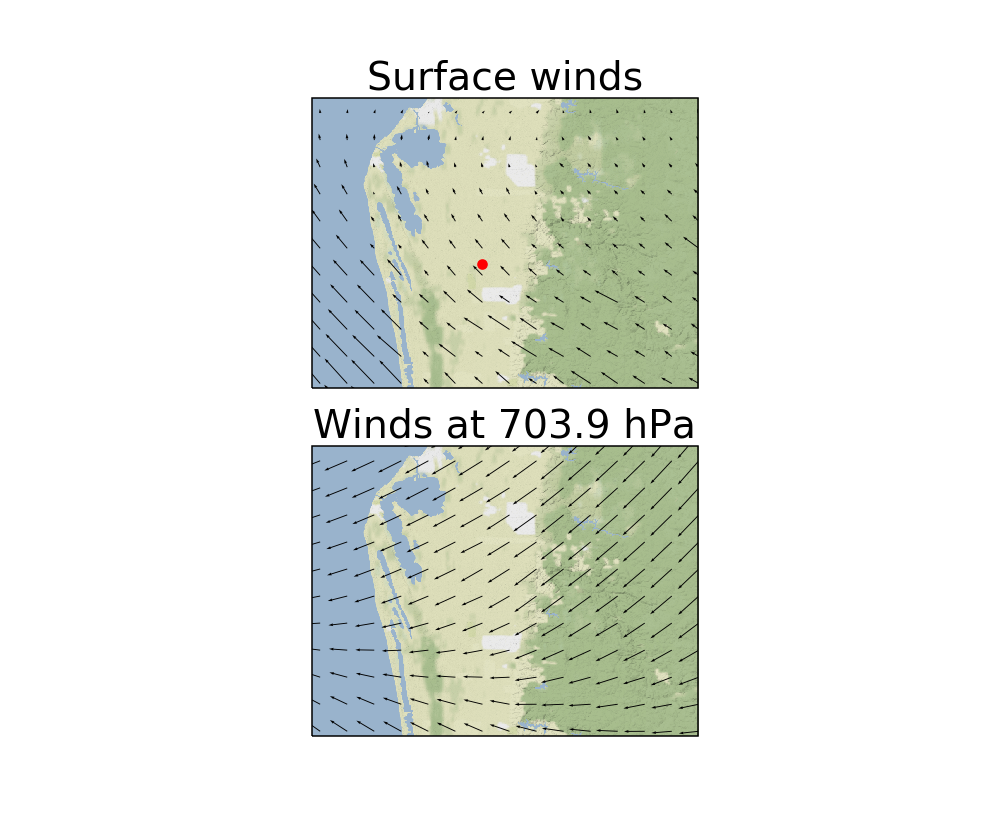

In [8]:
plt.close()

# Reduce resolution by skipping n-1 datapoints in every n
skiplen = 20
skip=(slice(None,None,skiplen),slice(None,None,skiplen))
latlr = lat[::skiplen]
lonlr = lon[::skiplen]
usurflr = u[0][skip]
vsurflr = v[0][skip]
zlev=65
uhighlr = u[zlev][skip] # higher altitude winds
vhighlr = v[zlev][skip]
arrowscale=70 # smaller number makes arrows huge in quiver plot

fig = plt.figure()
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(2, 1, 1, projection=proj)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 11.
ax.add_image(stamen_terrain, 11)


# Add a marker for waroona volcano. LON, LAT, ... argument order important!
plt.plot(latlons['waroona'][1], latlons['waroona'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)

# PLOT THE QUIVER WITH WINDS
plt.title("Surface winds")
# Add arrows to show the wind vectors
plt.quiver(lonlr, latlr, usurflr, vsurflr, zorder=2,color='k', scale=arrowscale)


# Plot high winds too
ax2 = fig.add_subplot(2, 1, 2, projection=proj)

# Limit the extent of the map to a small longitude/latitude range.
ax2.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 14.
ax2.add_image(stamen_terrain, 11)
# Add a marker for waroona volcano. LON, LAT, ... argument order important!
plt.plot(latlons['waroona'][1], latlons['waroona'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)

# quiver at higher altitude
plt.title("Winds at %.1f hPa"%np.nanmean(p[zlev]/100.))
plt.quiver(lonlr, latlr, uhighlr, vhighlr, zorder=2,color='k',scale = arrowscale)


plt.show()

## Cross sectional plots

Need to add line showing cross section line on first plot

Cross section is based on interpolation (rectangular bivariate spline) in 2D along the line between start and end.

First the topography along the cross section is grabbed, as this will be shown in all cross sections

Four plots along cross section against shared height axis:
 - potential temperature
 - wind speeds
 - vertical velocity
 - water+ice kg / kg dry air


VERBOSE:utils.cross_section interpolation start and end points
  Nearest neighbour vs interp data:
         8.50      8.69
       317.41    322.47


<IPython.core.display.Javascript object>


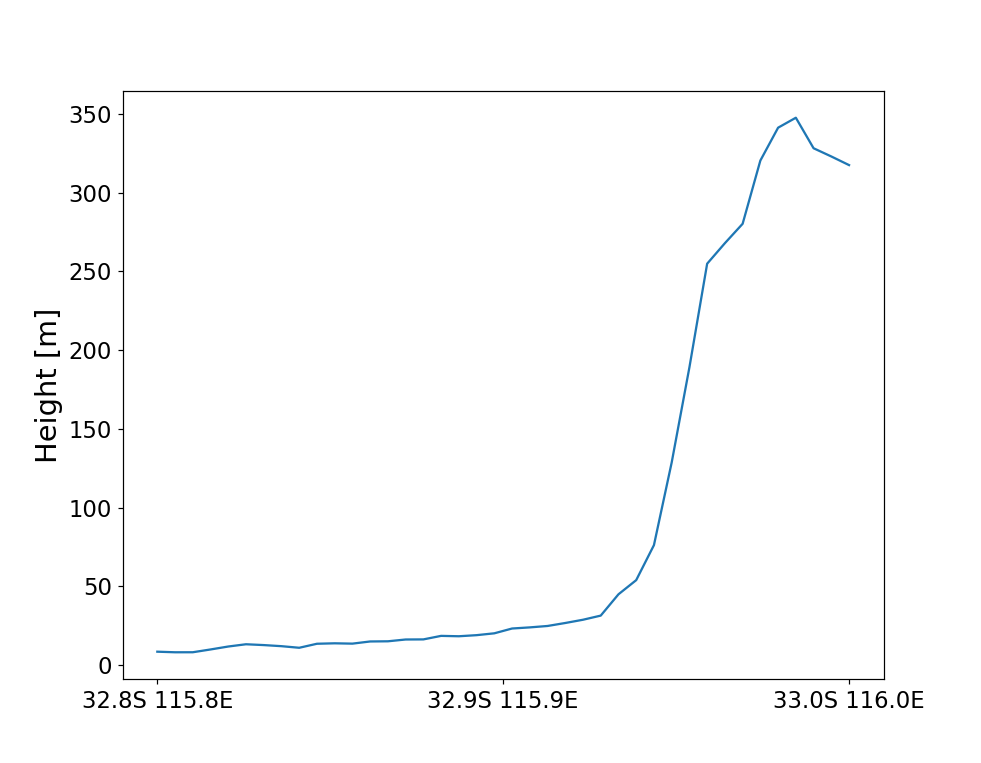

[  8.49994754   8.1321182    8.14601605   9.91342268  11.78721244
  13.21792913  12.69937442  11.99988307  10.9854103   13.5373648
  13.82320431  13.61372526  14.98980294  15.10152556  16.24009856
  16.30269166  18.54324756  18.3022996   18.99308927  20.16521712
  23.21475083  23.92887162  24.82403584  26.71741234  28.78104083
  31.40984135  44.93915065  53.92779847  76.15939488 128.59614781
 189.02605855 254.81488721 267.83624626 280.1450068  320.29475012
 341.15395815 347.47758911 328.10257868 322.88449299 317.40895194]


In [12]:

# cross section lat,lon start and finish
start,end = [-32.75,115.75],[-32.95,116]
npoints = 40

# Pull out cross section of topography
xtopog = utils.cross_section(topog,start,end, latt,lont,npoints=npoints)
xticks,xlabels = utils.cross_section_ticks_labels(start,end)
xaxis=np.linspace(0,1,npoints)
plt.figure()
plt.plot(xaxis,xtopog)
plt.xticks(xticks,xlabels)
plt.ylabel('Height [m]')
#plt.show()


## First image shows potential temp vs height
f,axes = plt.subplots(2,2)
plt.sca(axes[0,0])

xpt = utils.cross_section()

# Pull out cross section of potential temperature
